# Crossmap Code

## Setup

### Install dependencies

In [ ]:
!pip install qiskit
!pip install qiskit_optimization
!pip install qiskit_aer
!pip install qiskit_ionq

In [2]:
# Uncomment the lines below if you have access to an IONQ backend (specified in .env)

# import os
# from dotenv import load_dotenv
# load_dotenv()
# from qiskit_ionq import IonQProvider
# provider = IonQProvider(os.getenv('IONQ_PROVIDER_TOKEN'))
# backend = provider.get_backend("ionq_simulator")  # use this one to access a simulator of a quantum computer
# backend = provider.get_backend("ionq_qpu.aria-1") # use this one to access the actual quantum hardware called "aria-1"

In [3]:
from qiskit import *
from qiskit.visualization import *
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer


In [4]:
import numpy as np
from qiskit_optimization.algorithms import ADMMOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_aer import Aer
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import ADMMOptimizer, MinimumEigenOptimizer, ADMMParameters
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
qp = QuadraticProgram()

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Utility functions

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to plot the matrix with color-coding and grid lines
def plot_colored_matrix_with_grid(matrix, none_entry_color='white', cmap='Blues'):
    # Convert the matrix to a numpy array for easier manipulation
    matrix_np = np.array(matrix)

    # Replace 0 with NaN to handle color map
    matrix_with_nan = np.where(matrix_np == 0, np.nan, matrix_np)

    # Create a custom colormap that includes the none_entry_color for NaN values
    cmap = plt.get_cmap(cmap)
    cmap.set_bad(color=none_entry_color)

    # Check if the matrix is all NaNs
    if np.all(np.isnan(matrix_with_nan)):
        norm = mcolors.Normalize(vmin=0, vmax=1)  # Default normalization
    else:
        norm = mcolors.Normalize(vmin=0, vmax=np.nanmax(matrix_with_nan))

    # Dynamically adjust figure size based on matrix dimensions
    fig_width = max(8, matrix_np.shape[1] // 10)  # Adjust width dynamically
    fig_height = max(8, matrix_np.shape[0] // 10)  # Adjust height dynamically
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Use imshow to display the matrix, with grid lines and the color map
    cax = ax.imshow(matrix_with_nan, cmap=cmap, norm=norm, interpolation='nearest')

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, matrix_np.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, matrix_np.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    # Hide ticks in the minor grid
    ax.tick_params(which='minor', size=0)

    # Handle large matrices by reducing the number of displayed ticks
    if matrix_np.shape[1] > 50 or matrix_np.shape[0] > 50:
        xtick_step = max(1, matrix_np.shape[1] // 10)
        ytick_step = max(1, matrix_np.shape[0] // 10)
        ax.set_xticks(np.arange(0, matrix_np.shape[1], xtick_step))
        ax.set_yticks(np.arange(0, matrix_np.shape[0], ytick_step))
    else:
        ax.set_xticks(np.arange(matrix_np.shape[1]))
        ax.set_yticks(np.arange(matrix_np.shape[0]))

    # Set axis labels (matching the number of ticks with labels)
    ax.set_xticklabels(np.arange(0, matrix_np.shape[1], xtick_step) if matrix_np.shape[1] > 50 else np.arange(matrix_np.shape[1]))
    ax.set_yticklabels(np.arange(0, matrix_np.shape[0], ytick_step) if matrix_np.shape[0] > 50 else np.arange(matrix_np.shape[0]))

    # Add color bar for reference
    plt.colorbar(cax)

    # Display the plot
    plt.show()

In [7]:
# Create a 2D matrix filled with 0s and place nodes with optional radius metric
# Returns a 'rows' by 'cols' 2D Array 
def create_matrix(rows, cols, node_placements=None, radius=None):
    # Initialize the matrix with 0s
    matrix = [[0 for _ in range(cols)] for _ in range(rows)]
    
    # If no node placements provided, return empty matrix
    if node_placements is None:
        return matrix

    # Helper function to check if coordinates are within matrix bounds
    def is_within_bounds(x, y):
        return 0 <= x < rows and 0 <= y < cols

    # Place nodes in the matrix
    for x0, y0 in node_placements:
        if is_within_bounds(x0, y0):
            # If radius is specified, limit the distance expansion
            limit_radius = radius if radius is not None else max(rows, cols)
            # Determine the bounding box
            x_min = max(0, x0 - limit_radius)
            x_max = min(rows - 1, x0 + limit_radius)
            y_min = max(0, y0 - limit_radius)
            y_max = min(cols - 1, y0 + limit_radius)
            # Iterate over the bounding box
            for x in range(x_min, x_max + 1):
                for y in range(y_min, y_max + 1):
                    if matrix[x][y] == 0:
                        # Compute Euclidean distance
                        dist = ((x - x0)**2 + (y - y0)**2)**0.5
                        # Calculate the value to be assigned
                        value = max(0, int(round(limit_radius - dist)))
                        if value > 0:
                            matrix[x][y] = value
    return matrix

In [ ]:
# Convert the matrix to a string with dynamic spacing, adjusting based on the symbol length
def matrix_to_string(matrix, none_entry_symbol='0'):
    # If the none_entry_symbol is more than 1 character (like '42'), we use wider spacing
    if len(str(none_entry_symbol)) > 1:
        max_width = max(len(str(cell)) for row in matrix for cell in row)
        cell_width = max(max_width, len(str(none_entry_symbol)))
    else:
        # For shorter symbols (like '-'), just use a single space
        cell_width = 1

    # Building the string representation of the matrix with appropriate spacing
    result = ""
    for row in matrix:
        row_str = ' '.join([f'{str(cell):>{cell_width}}' if cell != 0 else f'{none_entry_symbol:>{cell_width}}' for cell in row])
        result += row_str + "\n"
    
    return result

# Example usage
matrix = create_matrix(10, 10, [(3, 3)], 4)
matrix_str = matrix_to_string(matrix, '-')
print(matrix_str)

In [ ]:
# Creates a list where every element is a 
# flattend version of a 2D matrix (with rows*cols dimensions).
# 
# Each list element represents one possible output of
# where the new optimized node placement could be. 

# This will be used to feed as the distance (D) input for the algorithm
def flatten_2D_to_1D(rows: int, cols: int, node_placements: list = [], radius: int = 2) -> list:
  D = []
  j = []
  count = 0
  for x in range(rows):
    for y in range(cols):
      count+=1
      matrix = create_matrix(rows, cols, node_placements + [(x, y)], radius)
      
      # Replace entry (i,j) with a 1, to represent one possibility
      for i in matrix:
        j = j + i
      D.append(j)
      j = []

  return D

# Example 1:
D = flatten_2D_to_1D(1, 3, [], 1)
print(D)

# Example 2:
D = flatten_2D_to_1D(1, 3, [], 2)
print(D)

In [ ]:
# Unflatten a 1D array back into a 2D matrix representation 

# This will later be used for printing the results of the algorithm
def unflatten_1D_to_2D_matrix(D: list, rows: int, cols: int, radius = 2):
    unflattened = []
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(D[i * cols + j])
        unflattened.append(row)
    
    # Create the matrix using the unflattened data
    node_placements = [(i, j) for i in range(rows) for j in range(cols) if unflattened[i][j] != 0]
    matrix = create_matrix(rows, cols, node_placements, radius)
    
    return matrix

# Example 1:
x_star = [0, 0, 0, 0, 1, 0, 0, 0, 0]
result = unflatten_1D_to_2D_matrix(x_star, 3, 3)
print(result)

# # Example 2:
x_star = [0, 1, 0]
result = unflatten_1D_to_2D_matrix(x_star, 1, 3)
print(result)

## Results

### Input:

Example 2: Create an empty 2x3 matrix
Input: [[2, 1, 0, 1, 1, 0], [1, 2, 1, 1, 1, 1], [0, 1, 2, 0, 1, 1], [1, 1, 0, 2, 1, 0], [1, 1, 1, 1, 2, 1], [0, 1, 1, 0, 1, 2]]
Matrix representation:
0 0 0
0 0 0



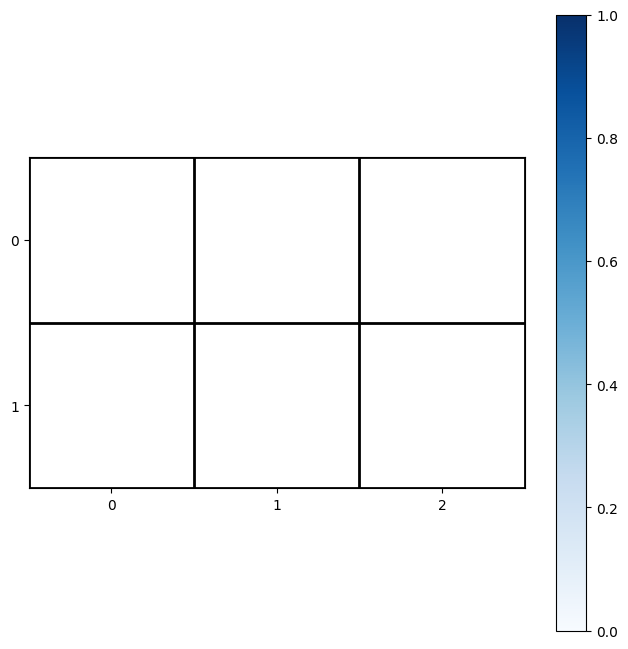

In [67]:
# Example : Create an empty 1x3 matrix
# rows = 1
# cols = 3

print("Example 2: Create an empty 2x3 matrix")
rows = 2
cols = 3

matrix = create_matrix(rows, cols)
D = flatten_2D_to_1D(rows, cols)

print("Input: " + str(D))
print("Matrix representation:\n" + str(matrix_to_string(matrix)))


plot_colored_matrix_with_grid(matrix)

### Algorithm:

In [ ]:
D  = np.asarray(D)
rho = 1.1
mu0 = 1
k = 0
# Define the function L(x, z, lambda, mu) you want to optimize
def L(x, z, lambda_, mu):
    term1 = np.transpose(np.ones(len(D))) * x  # (1^T)x
    term2 = np.transpose(lambda_)*D*x
    term3 = (mu/2)*(np.transpose(x)*np.transpose(D)*D*x - np.transpose(np.ones(len(D)) + z)*D*x)
    return term1 + term2 + term3

# Define the constraint function c(x, z)
def c(x,z):
    x_reshaped = x.reshape((-1, 1))  # Reshape x to be compatible with D
    return np.dot(D, x_reshaped) - np.ones_like(z) - z  # Use np.ones_like to match z's sha

def Theta(z):
    return np.array([1 if zi < 0 else 0 for zi in z])

# Initialize parameters
z_star = np.zeros_like(D)
lambda_star = np.zeros_like(D)
mu_star = mu0

# Set up the quantum instance
rho_initial = 1.1
factor_c = 10.0
beta = 100.0
maxiter = 100
admm_params = ADMMParameters(rho_initial=rho_initial, factor_c=factor_c, beta=beta, maxiter=maxiter)
sampler = Sampler()
qubo_optimizer = MinimumEigenOptimizer(QAOA(sampler = sampler, optimizer=COBYLA()))

admm_optimizer = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer)


'''
rhs = 1
linear_coeffs = {}
for i in range(len(D)):
    linear_coeffs[f'x_{i}'] = D[i, 0]  # Access the first element of the array
qp.linear_constraint(linear=linear_coeffs, sense='==', rhs=rhs)
'''
# Initialize the optimizer

# Optimization loop
converged = False
while not converged:
  k += 1
  qp = QuadraticProgram()
  # Add variables to qp as necessary
  for i in range(len(D)):
      qp.binary_var(name=f'x_{i}')
  # Linear terms
  linear_terms = {}
  for i in range(len(D)):
      # Calculate the dot product and store the result as a single number
      linear_terms[f'x_{i}'] = 1 + np.dot(lambda_star[i, :], D[:, i]) - 0.5 * mu_star * np.dot((1 + z_star[i, :]), D[:, i])  # Use slicing instead of flattening

  # Quadratic terms
  quadratic_terms = {}
  for i in range(len(D)):
      for j in range(i, len(D)):
          quadratic_terms[(f'x_{i}', f'x_{j}')] = 0.5 * mu_star * np.dot(D[:, i], D[:, j])

  # Define the objective function and constraints in qp
  #qp.minimize(lambda x: L(x, z_star, lambda_star, mu_star))
  qp.minimize(linear=linear_terms, quadratic=quadratic_terms)

  # Step 5: Use a quantum annealer (QAOA here) to minimize L(x, z*, lambda*, mu*)
  result = admm_optimizer.solve(qp)
  if (k == 1):
      circuit = qubo_optimizer.min_eigen_solver.ansatz
      print(circuit)
  x_star = result.x[:9]
  print(x_star)
  # Step 6: Optimization for z
  z_temp = z_star
  z_star = np.maximum(np.zeros_like(D), c(x_star, z_star)+z_star)
  #print("z",z_star)
  # Step 7: Update lambda_star
  lambda_star = lambda_star + mu_star * c(x_star, z_star)
  #print(lambda_star)
  # Step 8: Update mu_star (this depends on your specific update rule)
  ten_percent_mu = 0.1 * mu_star
  #print(np.linalg.norm(c(x_star, z_star)))
  #print(np.linalg.norm(D * -1*(z_temp - z_star)))
  if np.linalg.norm(c(x_star, z_star)) > 10 * mu_star * np.linalg.norm(D * -1*(z_temp - z_star)):
    mu_star = rho*mu_star
  elif 10 * mu_star * np.linalg.norm(c(x_star, z_star)) < np.linalg.norm(D * -1*(z_temp - z_star)):
    mu_star = mu_star/rho

  # Step 9: Check convergence criterion
  if k == 5:
    converged = True
# Output the optimized values
print(f"x*: {x_star}) #, z*: {z_star}, lambda*: {lambda_star}, mu*: {mu_star}")

print(admm_optimizer)

### Output 
Plots the result from running the above algorithm.

Result: [[1, 2, 1], [1, 1, 1]]
Matrix representation: 
1 2 1
1 1 1



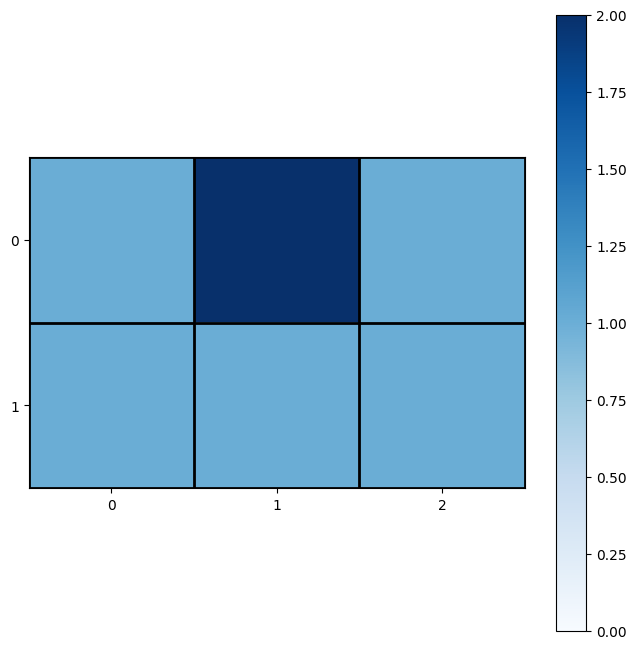

In [68]:
result = unflatten_1D_to_2D_matrix(x_star, rows, cols)
print(f"Result: {result}")
print(f"Matrix representation: \n{matrix_to_string(result)}")
plot_colored_matrix_with_grid(result)